In [ ]:
#!pip install demoji

In [ ]:
#!pip install textblob

In [ ]:
#!pip install afinn

In [ ]:
#!pip install wordcloud

In [ ]:
# !pip install textblob-fr

In [ ]:
#!pip install plotly

In [48]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import plotly
import re
import matplotlib
import plotly.express as px
import seaborn as sns
import datetime
import spacy
import random
from afinn import Afinn
from datetime import *
import demoji
from wordcloud import WordCloud
from textblob import TextBlob
from textblob import TextBlob, Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
import nltk
from nltk.corpus import stopwords
from random import random, seed
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.api as sm
import scipy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
pd.options.display.max_colwidth = 10000

In [3]:
nlp = spacy.load('fr_core_news_md')

# Introduction

# Traitement des données

In [4]:
df_tweets = pd.read_csv("~/work/projetpy/csv_tweets/tweets_vaccins.csv")

Un même tweet peut être posté par le même auteur à des heures différentes. La cellule ci-dessous permet de supprimer ces tweets dupliqués qui ont des valeurs communes de *texte* et *type_vaccin*. Ceratins tweets citent plus d'un vaccin, leurs repétitions selon *texte* et *type_vaccin* est légitime et ne seront pas pris en compte dans la suppression.

In [5]:
df_tweets["datetime"] = df_tweets["date"].apply(lambda x : datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

df_tweets["date"] = df_tweets["datetime"].apply(datetime.date)

In [6]:
df_tweets.drop_duplicates(subset = ["texte", "type_vaccin"], keep = 'first', inplace=True, ignore_index = True)

In [7]:
df_tweets.head(5)

,date,id,nbre_like,nbre_retweet,screenName,texte,type,type_vaccin,datetime
0,2021-03-01,1366184519662006274,1,0,yokko_mars,"@silvano_trotta Au Japon, on refuse le don de sang de personnes vaccinées, peut-être #Pfizer travaille-il à résoudre ce problème ?\nhttps://t.co/HFMPvtEfPY",tweet,pfizer,2021-03-01 00:32:26
1,2021-03-01,1366299423781892098,2,0,Epcocorico,@France_Dessinee @Pfizer_France Tragique,tweet,pfizer,2021-03-01 08:09:01
2,2021-03-01,1366307752096768000,2,0,socarre,"@thierrycogne @dc_morel Vaccinons en pharmacie et chez les médecins, avec AztraZeneca et Janssen qui va arriver en avril. Ouvrons plus de RDV sur les centres de vaccinations pour Pfizer et Moderna. Espérons que des millions de vaccinations auront lieu entre avril et juin.🙏",tweet,janssen,2021-03-01 08:42:07
3,2021-03-01,1366307752096768000,2,0,socarre,"@thierrycogne @dc_morel Vaccinons en pharmacie et chez les médecins, avec AztraZeneca et Janssen qui va arriver en avril. Ouvrons plus de RDV sur les centres de vaccinations pour Pfizer et Moderna. Espérons que des millions de vaccinations auront lieu entre avril et juin.🙏",tweet,moderna,2021-03-01 08:42:07
4,2021-03-01,1366307752096768000,2,0,socarre,"@thierrycogne @dc_morel Vaccinons en pharmacie et chez les médecins, avec AztraZeneca et Janssen qui va arriver en avril. Ouvrons plus de RDV sur les centres de vaccinations pour Pfizer et Moderna. Espérons que des millions de vaccinations auront lieu entre avril et juin.🙏",tweet,pfizer,2021-03-01 08:42:07


In [8]:
df_tweets.shape

(6005, 9)

Ainsi, 6005 tweets ont été requétés via l'API sur la période allant du 01 mars 2021 au 26 décembre 2021.

### Nettoyage des données textuelles

Les tweets sont des objets "sales" et cela rend dificile leur manipulation. Pour la suite, il faudra les nettoyer et la foncttion transforme définie à cet effet sert à supprimer les caractères spéciaux, les émojis, les ponctuations, à tranformer les majuscules en minuscule, etc... Les tweets ainsi nettoyés sont contenus dans la variable "texte_propre"

In [9]:
def transforme(texte):
    texte = texte.lower() # mettre les mots en minuscule
    #retirer les liens
    for item in re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+").findall(texte):
        texte=texte.replace(item, "")
    # enlever le retour à la ligne
    texte = texte.replace("\n", "").replace("\r", "")
    # supprimer ",", "!", "?", "%", "(",")","/",'"', "$","£", "_", "-", "+", "*", "µ", ":","&,"§" 
    texte = re.sub(r"[,\!\?\%\(\)\/\"\$\£\-\+\*\µ,\:\&\§]", " ", texte) 
    # retirer les hashtags #
    for item in re.compile("([#]\w+)").findall(texte):
        texte=texte.replace(item, "")
    # retirer les apostrophes '
    for item in re.compile("([\’])").findall(texte):
        texte=texte.replace(item, " ")
    for item in re.compile("([\'])").findall(texte):
        texte=texte.replace(item, " ")
    # retirer les points de suspension
    for item in re.compile("([.]{1,5})").findall(texte):
        texte=texte.replace(item, "") 
    # retirer les personnes tagées
    for item in re.compile("([@]\w+)").findall(texte):
        texte=texte.replace(item, "")
    # retirer les adresses mail
    for item in re.findall('\S+@\S+', texte) :
        texte=texte.replace(item, "")
    # retire les mots contenant des chiffres
    texte = re.sub(r"[A-Za-z\.]*[0-9]+[A-Za-z%°\.]*", "", texte)
    # retirer les emojis
    for item in demoji.findall(texte):
        texte=texte.replace(item,"")
    return texte

In [10]:
df_tweets["texte_propre"] = df_tweets["texte"].apply(lambda x: transforme(x))
df_tweets

,date,id,nbre_like,nbre_retweet,screenName,texte,type,type_vaccin,datetime,texte_propre
0,2021-03-01,1366184519662006274,1,0,yokko_mars,"@silvano_trotta Au Japon, on refuse le don de sang de personnes vaccinées, peut-être #Pfizer travaille-il à résoudre ce problème ?\nhttps://t.co/HFMPvtEfPY",tweet,pfizer,2021-03-01 00:32:26,au japon on refuse le don de sang de personnes vaccinées peut être travaille il à résoudre ce problème
1,2021-03-01,1366299423781892098,2,0,Epcocorico,@France_Dessinee @Pfizer_France Tragique,tweet,pfizer,2021-03-01 08:09:01,tragique
2,2021-03-01,1366307752096768000,2,0,socarre,"@thierrycogne @dc_morel Vaccinons en pharmacie et chez les médecins, avec AztraZeneca et Janssen qui va arriver en avril. Ouvrons plus de RDV sur les centres de vaccinations pour Pfizer et Moderna. Espérons que des millions de vaccinations auront lieu entre avril et juin.🙏",tweet,janssen,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins avec aztrazeneca et janssen qui va arriver en avril ouvrons plus de rdv sur les centres de vaccinations pour pfizer et moderna espérons que des millions de vaccinations auront lieu entre avril et juin
3,2021-03-01,1366307752096768000,2,0,socarre,"@thierrycogne @dc_morel Vaccinons en pharmacie et chez les médecins, avec AztraZeneca et Janssen qui va arriver en avril. Ouvrons plus de RDV sur les centres de vaccinations pour Pfizer et Moderna. Espérons que des millions de vaccinations auront lieu entre avril et juin.🙏",tweet,moderna,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins avec aztrazeneca et janssen qui va arriver en avril ouvrons plus de rdv sur les centres de vaccinations pour pfizer et moderna espérons que des millions de vaccinations auront lieu entre avril et juin
4,2021-03-01,1366307752096768000,2,0,socarre,"@thierrycogne @dc_morel Vaccinons en pharmacie et chez les médecins, avec AztraZeneca et Janssen qui va arriver en avril. Ouvrons plus de RDV sur les centres de vaccinations pour Pfizer et Moderna. Espérons que des millions de vaccinations auront lieu entre avril et juin.🙏",tweet,pfizer,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins avec aztrazeneca et janssen qui va arriver en avril ouvrons plus de rdv sur les centres de vaccinations pour pfizer et moderna espérons que des millions de vaccinations auront lieu entre avril et juin
...,...,...,...,...,...,...,...,...,...,...
6000,2021-12-23,1473963528172277763,3,0,MonaCoCo67,"@LePoint Et ça tombe bien, la France va en recevoir 17,8 millions de doses d'ici mars 2022, suite à l'accord conclu en septembre entre l'UE et AstraZeneca pour mettre fin à leur contentieux... \n\nhttps://t.co/kpYxpPRdl0",tweet,astrazeneca,2021-12-23 10:27:44,et ça tombe bien la france va en recevoir millions de doses d ici mars suite à l accord conclu en septembre entre l ue et astrazeneca pour mettre fin à leur contentieux
6001,2021-12-23,1473973873456656389,0,1,MonaCoCo67,"@le_Parisien Et ça tombe bien, la France va en recevoir 17,8 millions de doses d'ici mars 2022, suite à l'accord conclu en septembre entre l'UE et AstraZeneca pour mettre fin à leur contentieux... \n\nhttps://t.co/kpYxpPRdl0",tweet,astrazeneca,2021-12-23 11:08:51,et ça tombe bien la france va en recevoir millions de doses d ici mars suite à l accord conclu en septembre entre l ue et astrazeneca pour mettre fin à leur contentieux
6002,2021-12-23,1474017257974120453,1,0,Guy5767,"@monicalova13 Deux astrazeneca et un moderna, sa doit le faire ☺",tweet,astrazeneca,2021-12-23 14:01:14,deux astrazeneca et un moderna sa doit le faire
6003,2021-12-26,1475079514103463939,1,0,ertseled491,@BriceOf_Lyon @Nouveau_Papy Je n’ai été vacciné qu’au moyen d’Astrazeneca et je n’ai aucun tracas. \nPar contre désormais j’en suis privé et pourtant je vais faire le rappel sans délai.,tweet,astrazeneca,2021-12-26 12:22:16,je n ai été vacciné qu au moyen d astrazeneca et je n ai aucun tracas par contre désormais j en suis privé et pourtant je vais faire le rappel sans délai

Pour créer les wordclouds, les mots vides du texte doivent être mis à jour spécifiquement pour le domaine du texte. En effet pour des tweets sur les vaccins Covid, certains mots comme *vaccin*, etc... pourraient ne pas avoir d'importance pour l'analyse.

In [11]:
stop_words = nlp.Defaults.stop_words
stop_words_covid = ["faire", "recevoir", "voir", "vaccin", "jour", "semaine", "mois", "dire", "venir", "centre", "annoncer""vouloir", "france", "français", "francais", "dose", "falloir", "contre", "vacciner", "vaccination", "pouvoir", "aller", "injection", "injecter", "covid", "vacciné", "falloir"]
stop_words = list(stop_words) + stop_words_covid
# stop_words 

In [12]:
def decoupe_lemmatise(text):
    nlp_text = nlp(text)
    dict_lemm = {token : token.lemma_ for token in nlp_text}
    # list_mot = text.split()
    list_mots = []
    for x in nlp_text : 
        if len(x) >= 0 :
            list_mots.append(dict_lemm[x])
    return ' '.join(list_mots)

In [13]:
df_tweets["liste_mots_lemmatises"] = df_tweets["texte_propre"].apply(decoupe_lemmatise)

In [15]:
# create a list of candidates
vaccins = df_tweets.type_vaccin.unique()
#create a list of responses for each candidate using a list comprehension
corpus = [' '.join(df_tweets[df_tweets.type_vaccin==vaccin].liste_mots_lemmatises) for vaccin in vaccins]

#instantiate a CountVectorizer object
# utilize the new STOP_WORDS list
cv = CountVectorizer(stop_words=stop_words, ngram_range=(1, 3))

# fit transform our text and create a dataframe with the result
X = cv.fit_transform(corpus)
X = X.toarray()

bow = pd.DataFrame(X, columns = cv.get_feature_names())
bow.index = vaccins
bow

/opt/conda/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'qu', 'quelqu'] not in stop_words.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aam,aam rah,aam rah nekhod,abaissement,abaissement progressif,abaissement progressif âge,abaisser,abaisser an,abaisser an âge,abaisser âge,...,𝘀𝗮𝗻𝘀,𝘀𝗮𝗻𝘀 𝗿𝗲𝗻𝗱𝗲𝘇,𝘀𝗮𝗻𝘀 𝗿𝗲𝗻𝗱𝗲𝘇 𝘃𝗼𝘂𝘀,𝘀𝗰𝗮𝗻𝗱𝗮𝗹𝗲𝘂𝘅,𝘀𝗰𝗮𝗻𝗱𝗮𝗹𝗲𝘂𝘅 rajouter,𝘀𝗰𝗮𝗻𝗱𝗮𝗹𝗲𝘂𝘅 rajouter scandale,𝘃𝗼𝘂𝘀,𝘃𝗼𝘂𝘀 an,𝘃𝗼𝘂𝘀 an aujourd,𝘃𝗼𝘂𝘀 an dimanche
pfizer,1,1,1,1,1,1,2,1,1,1,...,0,0,0,0,0,0,0,0,0,0
janssen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
moderna,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
astrazeneca,0,0,0,0,0,0,1,1,1,0,...,2,2,2,1,1,1,2,2,1,1


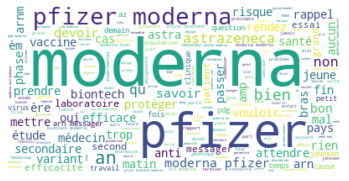

In [16]:
# create a pandas Series of the top 4000 most frequent words
text=bow.loc['moderna'].sort_values(ascending=False)[:4000]

# create a dictionary Note: you could pass the pandas Series directoy into the wordcloud object
text2_dict=bow.loc['moderna'].sort_values(ascending=False).to_dict()

# create the WordCloud object
wordcloud = WordCloud(min_word_length = 5,
                      background_color='white')

# generate the word cloud
wordcloud.generate_from_frequencies(text2_dict)

# plot
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [17]:
# text2_dict

### Calcul du sentiment d'un tweet à partir de la polarité de Textblob

In [18]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

In [19]:
def tweet_polarite(text):
    return tb(text).sentiment[0]

In [20]:
def tweet_label_car(text):
    if tweet_polarite(text) > 0 :
        return "positif"
    if tweet_polarite(text) < 0 :
        return "negatif"
    return "neutre"

In [21]:
def tweet_label(text):
    if tweet_polarite(text) > 0 :
        return 1
    if tweet_polarite(text) < 0 :
        return -1
    return 0

In [22]:
df_tweets["score_polarite"] = df_tweets["texte_propre"].apply(tweet_polarite)
df_tweets["label_car"] = df_tweets["texte_propre"].apply(tweet_label_car)
df_tweets["label"] = df_tweets["texte_propre"].apply(tweet_label)

Comme le montre la sortie ci-dessous, on niveau de la variable "label", on a les modalités -1, 0 et 1. -1 matérialise un sentiment négatif, 0 un sentiment neutre et 1 un sentiment positif comme regroupé dans la variable "label_car".

In [23]:
df_tweets.head()

,date,id,nbre_like,nbre_retweet,screenName,texte,type,type_vaccin,datetime,texte_propre,liste_mots_lemmatises,score_polarite,label_car,label
0,2021-03-01,1366184519662006274,1,0,yokko_mars,"@silvano_trotta Au Japon, on refuse le don de sang de personnes vaccinées, peut-être #Pfizer travaille-il à résoudre ce problème ?\nhttps://t.co/HFMPvtEfPY",tweet,pfizer,2021-03-01 00:32:26,au japon on refuse le don de sang de personnes vaccinées peut être travaille il à résoudre ce problème,au japon on refuse le don de sang de personne vacciner pouvoir être travaille il à résoudre ce problème,0.00,neutre,0
1,2021-03-01,1366299423781892098,2,0,Epcocorico,@France_Dessinee @Pfizer_France Tragique,tweet,pfizer,2021-03-01 08:09:01,tragique,tragique,-0.40,negatif,-1
2,2021-03-01,1366307752096768000,2,0,socarre,"@thierrycogne @dc_morel Vaccinons en pharmacie et chez les médecins, avec AztraZeneca et Janssen qui va arriver en avril. Ouvrons plus de RDV sur les centres de vaccinations pour Pfizer et Moderna. Espérons que des millions de vaccinations auront lieu entre avril et juin.🙏",tweet,janssen,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins avec aztrazeneca et janssen qui va arriver en avril ouvrons plus de rdv sur les centres de vaccinations pour pfizer et moderna espérons que des millions de vaccinations auront lieu entre avril et juin,vaccinon en pharmacie et chez le médecin avec aztrazeneca et janssen qui aller arriver en avril ouvrir plus de rendez-vous sur le centre de vaccination pour pfizer et moderna espérer que un million de vaccination avoir lieu entre avril et juin,0.15,positif,1
3,2021-03-01,1366307752096768000,2,0,socarre,"@thierrycogne @dc_morel Vaccinons en pharmacie et chez les médecins, avec AztraZeneca et Janssen qui va arriver en avril. Ouvrons plus de RDV sur les centres de vaccinations pour Pfizer et Moderna. Espérons que des millions de vaccinations auront lieu entre avril et juin.🙏",tweet,moderna,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins avec aztrazeneca et janssen qui va arriver en avril ouvrons plus de rdv sur les centres de vaccinations pour pfizer et moderna espérons que des millions de vaccinations auront lieu entre avril et juin,vaccinon en pharmacie et chez le médecin avec aztrazeneca et janssen qui aller arriver en avril ouvrir plus de rendez-vous sur le centre de vaccination pour pfizer et moderna espérer que un million de vaccination avoir lieu entre avril et juin,0.15,positif,1
4,2021-03-01,1366307752096768000,2,0,socarre,"@thierrycogne @dc_morel Vaccinons en pharmacie et chez les médecins, avec AztraZeneca et Janssen qui va arriver en avril. Ouvrons plus de RDV sur les centres de vaccinations pour Pfizer et Moderna. Espérons que des millions de vaccinations auront lieu entre avril et juin.🙏",tweet,pfizer,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins avec aztrazeneca et janssen qui va arriver en avril ouvrons plus de rdv sur les centres de vaccinations pour pfizer et moderna espérons que des millions de vaccinations auront lieu entre avril et juin,vaccinon en pharmacie et chez le médecin avec aztrazeneca et janssen qui aller arriver en avril ouvrir plus de rendez-vous sur le centre de vaccination pour pfizer et moderna espérer que un million de vaccination avoir lieu entre avril et juin,0.15,positif,1


### Création de features

Pour bien mener la modélisation, nous extrayons des tweets certaines variables qui nous semblent être importantes comme par exemple les variables binaires renseignant sur le type de vaccin, le nombre de hashtags, de ponctuation, ...

In [24]:
# Création des 'dummy" variables
dummy_df = pd.get_dummies(df_tweets.type_vaccin, prefix="vaccin", prefix_sep='_', drop_first=False)
df_tweets[dummy_df.columns] = dummy_df

In [25]:
def decompte_hashtags(text):
    exp_match = re.compile("([#]\w+)")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_hashtags"] = df_tweets["texte"].apply(lambda x : decompte_hashtags(x))

In [26]:
def decompte_tags(text):
    exp_match = re.compile("([@]\w+)")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_tags"] = df_tweets["texte"].apply(lambda x : decompte_tags(x))

In [27]:
def decompte_exclamation(text):
    exp_match = re.compile("(\w?\s?[!])")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_exclamation"] = df_tweets["texte"].apply(lambda x : decompte_exclamation(x))

In [28]:
def decompte_mails(text):
    exp_match = re.compile("(\w+[@]\w+[.]\w+)")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_mails"] = df_tweets["texte"].apply(lambda x : decompte_mails(x))

In [29]:
def decompte_interrogation(text):
    exp_match = re.compile("(\w?\s?[?])")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_interrogation"] = df_tweets["texte"].apply(lambda x : decompte_interrogation(x))

In [30]:
def decompte_mot_maj(text):
    exp_match = re.compile("([A-Z][A-Z]+)")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_maj"] = df_tweets["texte"].apply(lambda x : decompte_mot_maj(x))

In [31]:
df_tweets.head()

,date,id,nbre_like,nbre_retweet,screenName,texte,type,type_vaccin,datetime,texte_propre,...,vaccin_astrazeneca,vaccin_janssen,vaccin_moderna,vaccin_pfizer,nbre_hashtags,nbre_tags,nbre_exclamation,nbre_mails,nbre_interrogation,nbre_maj
0,2021-03-01,1366184519662006274,1,0,yokko_mars,"@silvano_trotta Au Japon, on refuse le don de sang de personnes vaccinées, peut-être #Pfizer travaille-il à résoudre ce problème ?\nhttps://t.co/HFMPvtEfPY",tweet,pfizer,2021-03-01 00:32:26,au japon on refuse le don de sang de personnes vaccinées peut être travaille il à résoudre ce problème,...,0,0,0,1,1,1,0,0,1,2
1,2021-03-01,1366299423781892098,2,0,Epcocorico,@France_Dessinee @Pfizer_France Tragique,tweet,pfizer,2021-03-01 08:09:01,tragique,...,0,0,0,1,0,2,0,0,0,0
2,2021-03-01,1366307752096768000,2,0,socarre,"@thierrycogne @dc_morel Vaccinons en pharmacie et chez les médecins, avec AztraZeneca et Janssen qui va arriver en avril. Ouvrons plus de RDV sur les centres de vaccinations pour Pfizer et Moderna. Espérons que des millions de vaccinations auront lieu entre avril et juin.🙏",tweet,janssen,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins avec aztrazeneca et janssen qui va arriver en avril ouvrons plus de rdv sur les centres de vaccinations pour pfizer et moderna espérons que des millions de vaccinations auront lieu entre avril et juin,...,0,1,0,0,0,2,0,0,0,1
3,2021-03-01,1366307752096768000,2,0,socarre,"@thierrycogne @dc_morel Vaccinons en pharmacie et chez les médecins, avec AztraZeneca et Janssen qui va arriver en avril. Ouvrons plus de RDV sur les centres de vaccinations pour Pfizer et Moderna. Espérons que des millions de vaccinations auront lieu entre avril et juin.🙏",tweet,moderna,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins avec aztrazeneca et janssen qui va arriver en avril ouvrons plus de rdv sur les centres de vaccinations pour pfizer et moderna espérons que des millions de vaccinations auront lieu entre avril et juin,...,0,0,1,0,0,2,0,0,0,1
4,2021-03-01,1366307752096768000,2,0,socarre,"@thierrycogne @dc_morel Vaccinons en pharmacie et chez les médecins, avec AztraZeneca et Janssen qui va arriver en avril. Ouvrons plus de RDV sur les centres de vaccinations pour Pfizer et Moderna. Espérons que des millions de vaccinations auront lieu entre avril et juin.🙏",tweet,pfizer,2021-03-01 08:42:07,vaccinons en pharmacie et chez les médecins avec aztrazeneca et janssen qui va arriver en avril ouvrons plus de rdv sur les centres de vaccinations pour pfizer et moderna espérons que des millions de vaccinations auront lieu entre avril et juin,...,0,0,0,1,0,2,0,0,0,1


In [32]:
print("Ainsi, {:1d} tweets ont pu être requetés et {:1d} variables construites. Le dictionnaire de données est le suivant".format(df_tweets.shape[0], df_tweets.shape[1]))

Ainsi, 6005 tweets ont pu être requetés et 24 variables construites. Le dictionnaire de données est le suivant


Le dictionnaire de données est le suivant
+ date
+ id
+ nbre_like
+ nbre_retweet
+ screenName
+ texte
+ type
+ type_vaccin
+ datetime
+ texte_propre
+ score_polarite
+ label_car
+ label
+ vaccin_astrazeneca
+ vaccin_janssen
+ vaccin_moderna
+ vaccin_pfizer
+ nbre_hashtags
+ nbre_tags
+ nbre_exclamation
+ nbre_mails
+ nbre_interrogation
+ nbre_maj

# Exploratory Data Analysis

### Statistiques descriptives

In [33]:
round(df_tweets.describe(), 3)

,id,nbre_like,nbre_retweet,score_polarite,label,vaccin_astrazeneca,vaccin_janssen,vaccin_moderna,vaccin_pfizer,nbre_hashtags,nbre_tags,nbre_exclamation,nbre_mails,nbre_interrogation,nbre_maj
count,6.005000e+03,6005.000,6005.000,6005.000,6005.000,6005.000,6005.000,6005.000,6005.000,6005.000,6005.000,6005.000,6005.0,6005.000,6005.000
mean,1.409209e+18,8.904,2.974,0.071,0.347,0.230,0.026,0.169,0.574,1.051,1.231,0.345,0.0,0.265,1.281
std,3.169649e+16,109.422,34.282,0.195,0.793,0.421,0.161,0.375,0.494,2.256,1.626,0.898,0.0,0.727,1.903
min,1.366185e+18,0.000,0.000,-1.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000
25%,1.380763e+18,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000
50%,1.404481e+18,1.000,0.000,0.030,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.0,0.000,1.000
75%,1.430842e+18,2.000,0.000,0.160,1.000,0.000,0.000,0.000,1.000,1.000,2.000,0.000,0.0,0.000,2.000
max,1.475089e+18,6036.000,1879.000,1.000,1.000,1.000,1.000,1.000,1.000,24.000,23.000,12.000,0.0,10.000,28.000


Un apercu de la colonne *nbre_mails*, qui a des valeurs minimale et maximale de 0, montre qu'elle est sans intéret pour la suite.

In [34]:
df_tweets = df_tweets.drop("nbre_mails", axis=1)

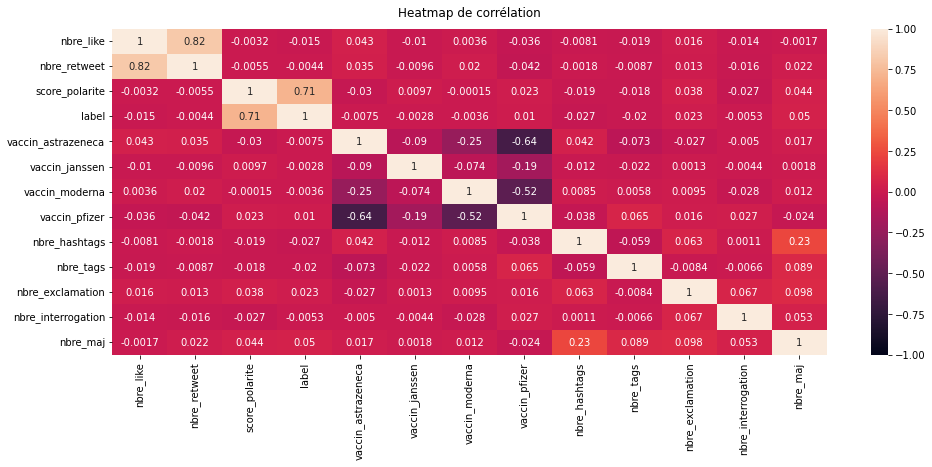

In [35]:
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(df_tweets.drop("id", axis=1).corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Heatmap de corrélation', fontdict={'fontsize':12}, pad=12);

Les variables *nbre_like* et *nbre_retweet* sont corrélées

In [36]:
df_tweets.groupby("type_vaccin")["id"].count()

type_vaccin
astrazeneca    1384
janssen         159
moderna        1013
pfizer         3449
Name: id, dtype: int64

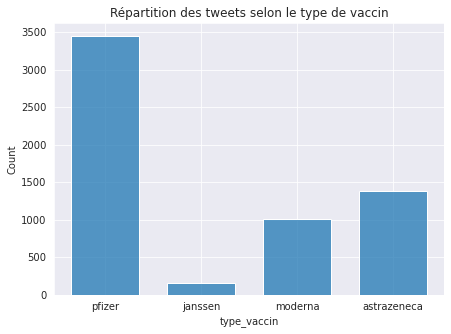

In [37]:
plt.figure(figsize=(7, 5))
sns.set_style('darkgrid')
sns.histplot(df_tweets, x="type_vaccin",  shrink=0.7)
plt.title("Répartition des tweets selon le type de vaccin")
plt.show()

Pfizer est le vaccin le plus populaire étant donné qu'environ 3500 tweets l'ont cité. Il est suivi de AstraZeneca avec 1384 mentions et Moderna avec environ 1000 mentions. Janssen est très faiblement représenté avec seulement 159 tweets. 

In [38]:
df_tweets.groupby("label_car")["id"].count()

label_car
negatif    1207
neutre     1508
positif    3290
Name: id, dtype: int64

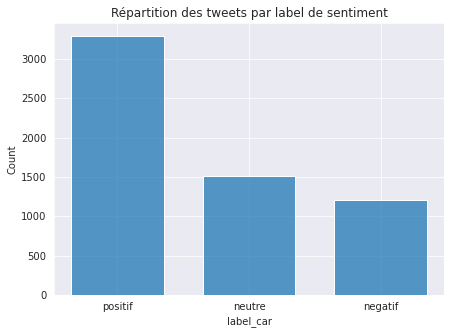

In [39]:
plt.figure(figsize=(7, 5))
sns.set_style('darkgrid')
# customPalette = sns.set_palette(sns.diverging_palette(150, 10, n=3))

sns.histplot(df_tweets.sort_values("label_car", ascending=False), x="label_car",  shrink=0.7)# , palette=customPalette)
plt.title("Répartition des tweets par label de sentiment")
plt.show()

Parmi tous les tweets, environ la moitié ont été désignés par TextBlob comme positifs en termes de sentiment (polarité = > 1), l'autre moitié étant constituée de 1203 tweets négatifs (polarité < 0,0) et de 1495 tweets neutres (polarité = 0).

In [40]:
df_tweets.groupby(["type_vaccin", "label_car"])["id"].count()

type_vaccin  label_car
astrazeneca  negatif       297
             neutre        325
             positif       762
janssen      negatif        34
             neutre         38
             positif        87
moderna      negatif       209
             neutre        250
             positif       554
pfizer       negatif       667
             neutre        895
             positif      1887
Name: id, dtype: int64

<Figure size 720x504 with 0 Axes>

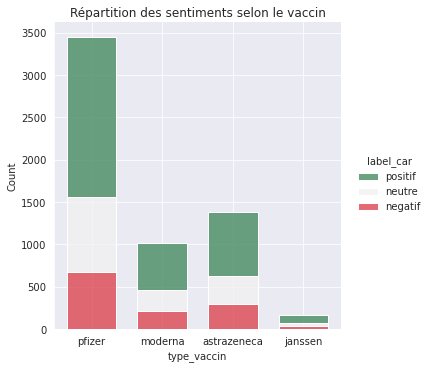

In [41]:
plt.figure(figsize=(10, 7))
# sns.color_palette("Spectral", as_cmap=True)
cpalette = sns.diverging_palette(140, 10, n=3)
sns.displot(df_tweets.sort_values("label_car", ascending=False), x="type_vaccin", hue="label_car", multiple="stack", shrink=0.7, palette=cpalette)
plt.title("Répartition des sentiments selon le vaccin")
plt.show()

Pour tous les types de vaccins, les tweets "positifs" sont les plus représentés suivi des tweets neutres et enfin des tweets négatifs. La population apprécie en moyenne tous les types de vaccin . 

### Analyse temporelle

Dans cette partie, nous verrons si nous pouvons explorer des tendances par rapport au temps.   
Premièrement, il est utile de visualiser la distribution temporelle de tous les tweets dans l'ensemble de données.

Text(0.5, 1.0, 'Fréquence des tweets par rapport au temps')

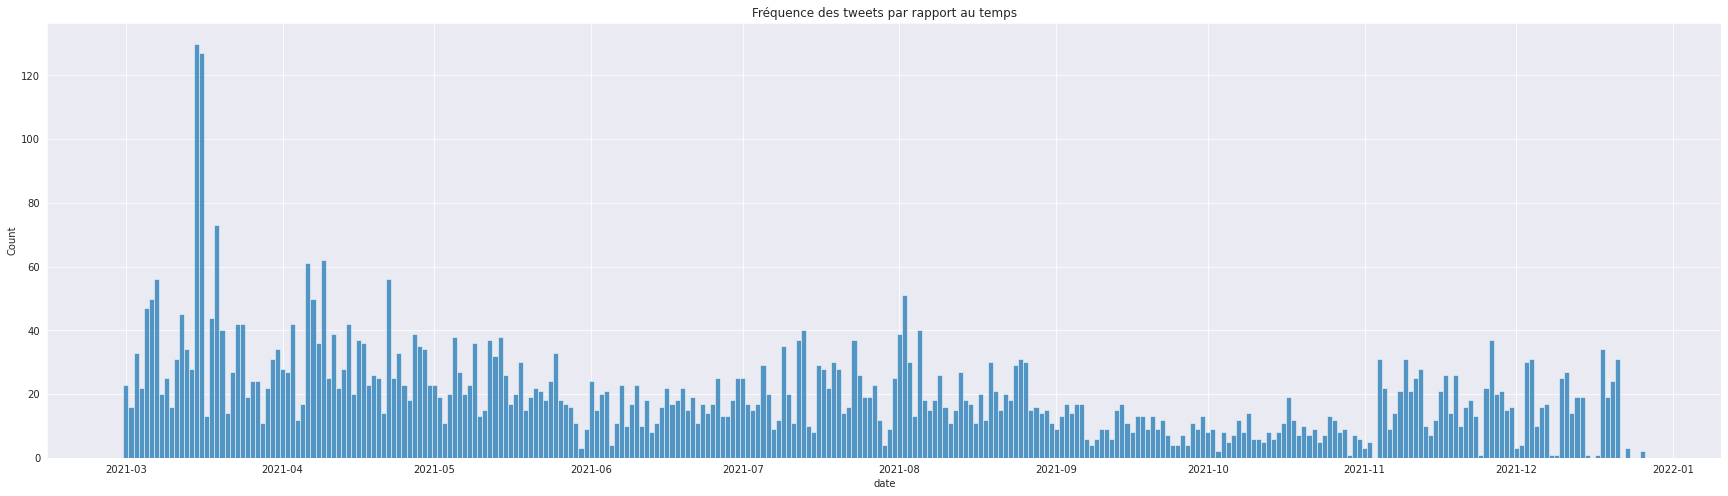

In [42]:
plt.figure(figsize=(30, 8))
sns.set_style('darkgrid')
sns.histplot(df_tweets, x="date")
plt.title("Fréquence des tweets par rapport au temps")

Les mois de mars, avril et aout ont connu de nombreux tweets sur les vaccins. Cela est sans doute dû aux mesures restrictives annoncées pour les vacances d'été et les rentrées adminitratives de septembre. 

In [43]:
df_date = df_tweets.groupby(['date']).agg(np.nanmean).reset_index()
df_date['nbre_tweet'] = df_tweets.groupby(['date']).count().reset_index()['id']
df_date = df_date[['date', 'nbre_tweet', 'score_polarite', 'nbre_like']]
df_date["score_polarite"] = df_date["score_polarite"].astype(float)
# df_date['nbre_tweet']

In [44]:
# plt.figure(figsize=(30, 8))
# plot = plt.scatter(df_date.index, df_date['nbre_tweet'], c=df_date['score_polarite'], cmap='coolwarm')
# plt.clf()
# plt.colorbar(plot)
# ax = sns.barplot(x=df_date.index, y=df_date['nbre_tweet'], hue=df_date['score_polarite'], palette='coolwarm', dodge=False)
# ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(prune='both', nbins=11))
# ax.set(xlabel="Date",
#       ylabel="nombre_tweets",
#       title="Score de polarité moyen pour les tweets agrégés par date")
# ax.legend_.remove()

### Visualisation avec WordCloud

On se propose ici de visualiser les wordclouds selon le sentiment et selon le vaccin.

In [51]:
# définition des couleurs pour distinguer les wordclouds par type de sentiments
import random 

def couleur_rouge(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)" 

def couleur_vert(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)" 

def couleur_jaune(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)" 

In [52]:
def plot_wordcloud_label() :
    for x in df_tweets["type_vaccin"].unique():
        stop_words.append(x)
    # joindre les tweets en une chaine de caractere par type de sentiment
    df_pos = df_tweets[df_tweets['label']==1]
    mots_pos = ' '.join(df_pos['liste_mots_lemmatises'])
    
    df_neg = df_tweets[df_tweets['label']==-1]
    mots_neg = ' '.join(df_neg['liste_mots_lemmatises'])
    
    df_neu = df_tweets[df_tweets['label']==0]
    mots_neu = ' '.join(df_neu['liste_mots_lemmatises'])
    
    fig, axes = plt.subplots(1,3, figsize=(25,25))
    
    wordcloud_neg = WordCloud(stopwords=stop_words,
                          background_color='white',
                          collocations=False, collocation_threshold=100,
                          max_words=75, min_word_length=4, colormap='Reds'
                         ).generate(mots_neg)
    axes[0].imshow(wordcloud_neg.recolor(color_func=couleur_rouge, random_state=3), interpolation='bilinear')
    axes[0].set_title("Sentiment négatif")
    axes[0].axis("off")

    wordcloud_neu = WordCloud(stopwords=stop_words,
                          background_color='white',
                          collocations=False, collocation_threshold=100,
                          max_words=75, min_word_length=4, colormap='Greens'
                         ).generate(mots_neu)
    axes[1].imshow(wordcloud_neu.recolor(color_func=couleur_jaune, random_state=3), interpolation='bilinear')
    axes[1].set_title("Sentiment neutre")
    axes[1].axis("off")

    wordcloud_pos = WordCloud(stopwords=stop_words,
                          background_color='white', collocations=False, collocation_threshold=100,
                          max_words=75, min_word_length=4, colormap='Greens'
                         ).generate(mots_pos)
    axes[2].imshow(wordcloud_pos.recolor(color_func=couleur_vert, random_state=3), interpolation='bilinear')
    axes[2].set_title("Sentiment positif")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show();
    # return fig

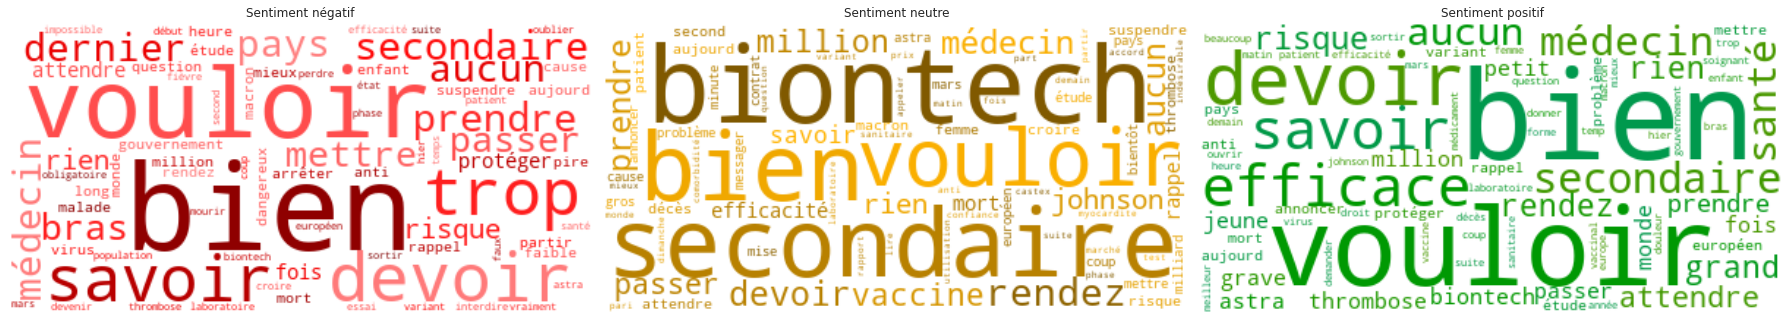

In [53]:
plot_wordcloud_label()

In [54]:
def plot_wordcloud_vaccin(vaccin) :
    vaccin=str(vaccin)
    for x in df_tweets["type_vaccin"].unique():
        stop_words.append(x)
    df_cloud = df_tweets[df_tweets['type_vaccin']==vaccin] 
    df_pos = df_cloud[df_cloud['label']==1]
    mots_pos = ' '.join(df_pos['liste_mots_lemmatises'])
    
    df_neg = df_cloud[df_cloud['label']==-1]
    mots_neg = ' '.join(df_neg['liste_mots_lemmatises'])
    
    df_neu = df_cloud[df_cloud['label']==0]
    mots_neu = ' '.join(df_neu['liste_mots_lemmatises'])
    
    fig, axes = plt.subplots(1,3, figsize=(25,25))
    
    wordcloud_neg = WordCloud(stopwords=stop_words,
                          background_color='white',
                          collocations=False, collocation_threshold=100,
                          max_words=100, min_word_length=4, colormap='Reds'
                         ).generate(mots_neg)
    axes[0].imshow(wordcloud_neg.recolor(color_func=couleur_rouge, random_state=3), interpolation='bilinear')
    axes[0].set_title("Sentiment négatif")
    axes[0].axis("off")

    wordcloud_neu = WordCloud(stopwords=stop_words,
                          background_color='white',
                          collocations=False, collocation_threshold=100,
                          max_words=100, min_word_length=4, colormap='Greens'
                         ).generate(mots_neu)
    axes[1].imshow(wordcloud_neu.recolor(color_func=couleur_jaune, random_state=3), interpolation='bilinear')
    axes[1].set_title("Sentiment neutre")
    axes[1].axis("off")

    wordcloud_pos = WordCloud(stopwords=stop_words,
                          background_color='white', collocations=False, collocation_threshold=100,
                          max_words=100, min_word_length=4, colormap='Greens'
                         ).generate(mots_pos)
    axes[2].imshow(wordcloud_pos.recolor(color_func=couleur_vert, random_state=3), interpolation='bilinear')
    axes[2].set_title("Sentiment positif")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show();

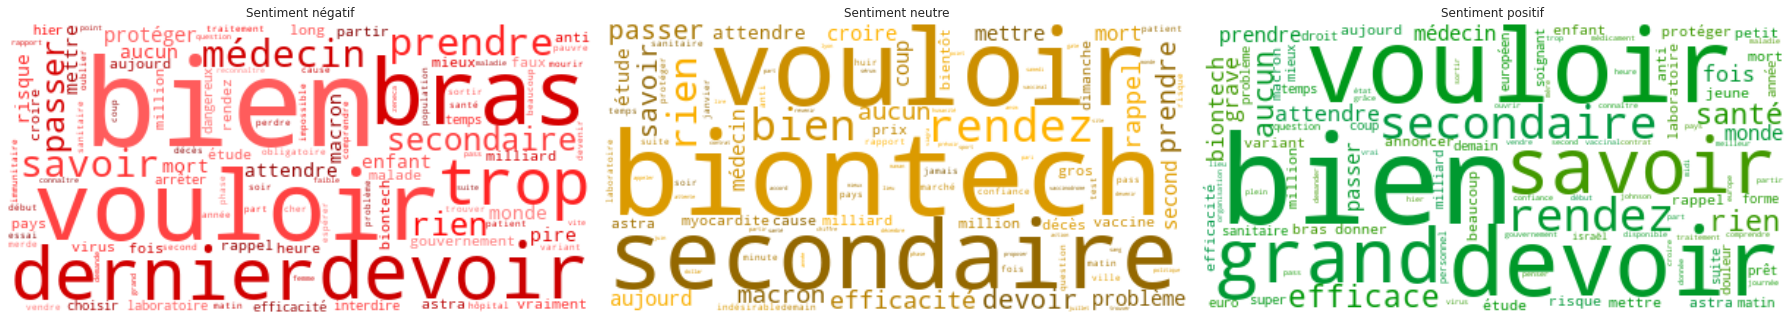

In [55]:
plot_wordcloud_vaccin("pfizer")

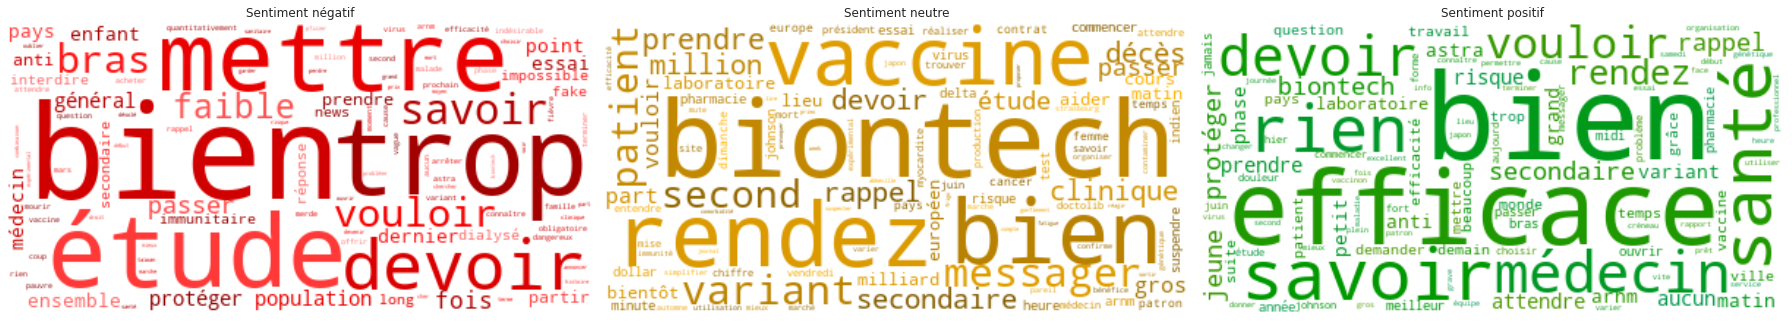

In [56]:
plot_wordcloud_vaccin("moderna")

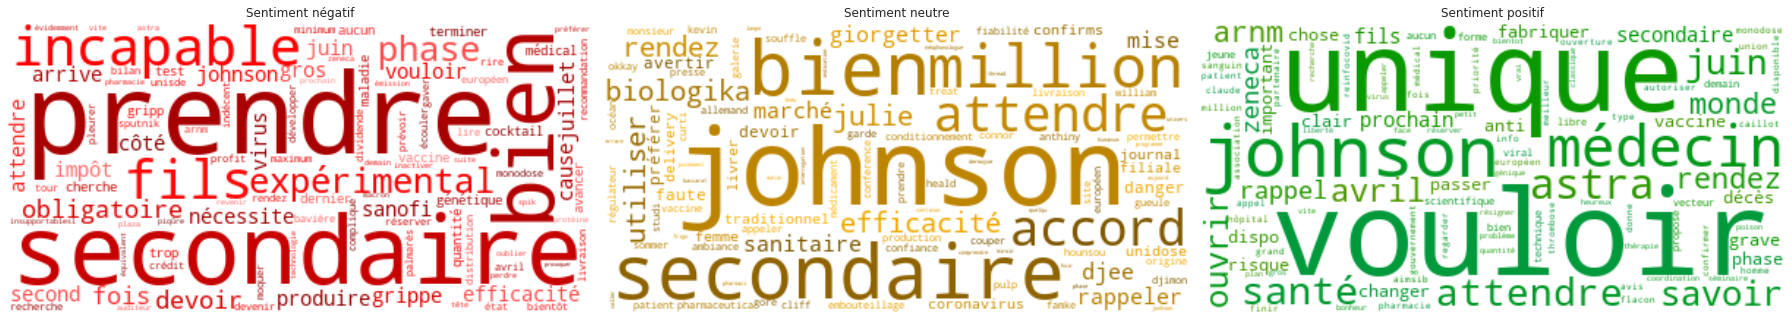

In [57]:
plot_wordcloud_vaccin("janssen")

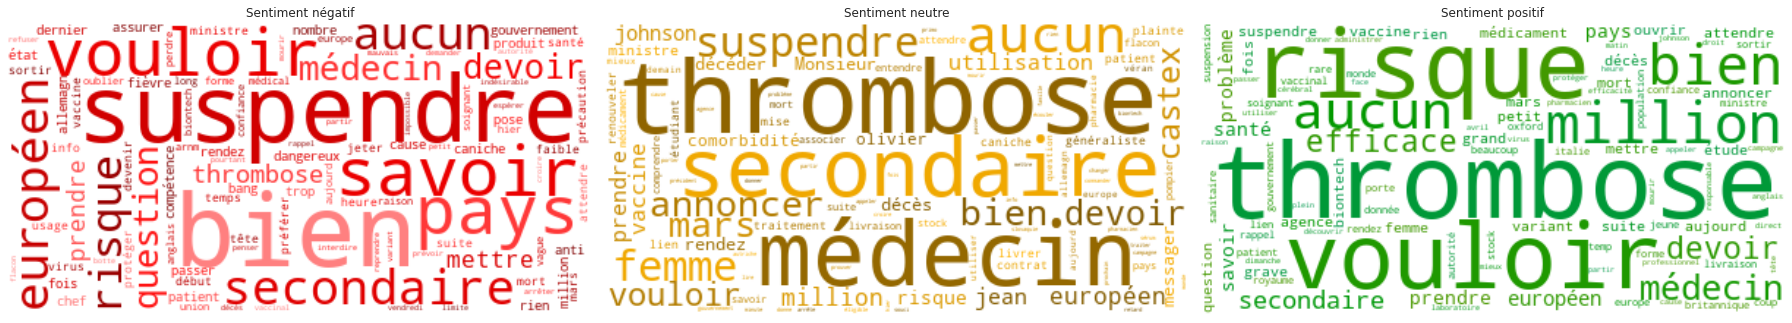

In [58]:
plot_wordcloud_vaccin("astrazeneca")

# Modélisation

Cette section concerne la modélisation où une classification word2vec sera implémentée 